In [1]:
import pandas as pd

In [2]:
# In a first step, the input prices are loaded. We take day-ahead GErman spot market prices

df = pd.read_csv("./input/Hourly_EV_Charging.csv") # only for index, the actual EV data is handled separatel
df = df.iloc[:8760]

df_price = pd.read_excel("./input/Gro_handelspreise_202101010000_202112312359_Stunde (2).xlsx", skiprows=9)
df_p = pd.DataFrame()
df_p.index = df.index
# MWh prices are transformed to kWh prices
df_p["Deutschland/Luxemburg [€/kWh]"] = df_price["Deutschland/Luxemburg [€/MWh]"].apply(lambda x: x/1000).values
min_price = df_p["Deutschland/Luxemburg [€/kWh]"].min()
df_p["Deutschland/Luxemburg [€/kWh]"] = df_p["Deutschland/Luxemburg [€/kWh]"].apply(lambda x: x+abs(min_price)) # avoid negative values for optimization
df_p.head()

/Users/leosemmelmann/opt/anaconda3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Deutschland/Luxemburg [€/kWh]
0,0.11987
1,0.11719
2,0.11368
3,0.11192
4,0.10939


In [3]:


# Please make sure that the desired set of settings has been calculated
def settings_to_costs_df(pricing_type, operation_type, feed_in_tariff,grid_charges, handling_fee): 
    target_df = pd.read_pickle(f"./output/00_pricing_{pricing_type}_operation_{operation_type}_fi_{str(feed_in_tariff)}_ne_{str(grid_charges).replace('.','')}.pkl")
    df_p.index = target_df.index

    if pricing_type == "constant":
        df_p["Deutschland/Luxemburg [€/kWh]"]  = df_p["Deutschland/Luxemburg [€/kWh]"].mean()

    target_df_costs = target_df.copy()

    for col in target_df.columns:
        for idx in target_df.index:
            if target_df[col][idx] < 0:
                target_df_costs[col][idx] = target_df[col][idx] * feed_in_tariff
            else:
                target_df_costs[col][idx] = target_df[col][idx] * (df_p["Deutschland/Luxemburg [€/kWh]"][idx]+grid_charges+handling_fee)
    return target_df_costs

In [4]:

feed_in_tariff = 0.07
grid_charges = 0.072
handling_fee = 0.02

pricing_type = "constant"
operation_type = "constant"

constant = settings_to_costs_df(pricing_type, operation_type, feed_in_tariff,grid_charges, handling_fee)


In [6]:

pricing_type = "dynamic"
operation_type = "dynamic"

dynamic = settings_to_costs_df(pricing_type, operation_type, feed_in_tariff,grid_charges, handling_fee)

<AxesSubplot: >

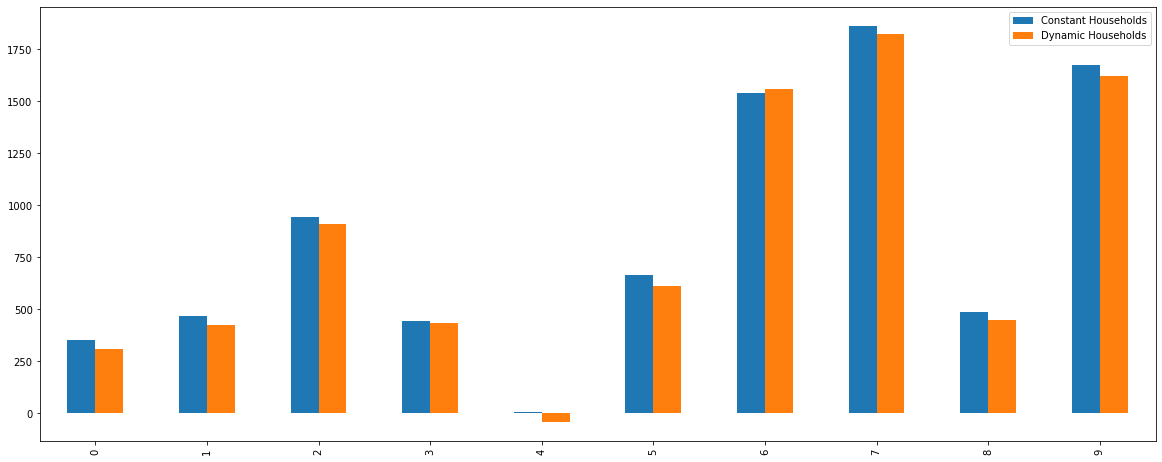

In [7]:
comparison = pd.DataFrame()

comparison["Constant Households"] = constant.sum()
comparison["Dynamic Households"] = dynamic.sum()

comparison.plot.bar(figsize=(20,8))



In [8]:
comparison

,Constant Households,Dynamic Households
0,350.949904,309.746267
1,467.265376,424.307476
2,941.381024,906.891711
3,444.964777,433.577821
4,5.017844,-39.973711
5,662.097588,609.991252
6,1539.975391,1555.225553
7,1858.670634,1823.341065
8,487.14594,450.472997
9,1674.923754,1618.365983
